In [520]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pandas as pd
import numpy as np
import random
import os

In [521]:
def set_seeds(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seeds(42)

In [522]:
spark = SparkSession.builder \
            .appName("VBMA VAR") \
            .config("spark.sql.catalog.nessie.ref", "feature/fact-macro-build") \
            .getOrCreate()

### Load data from Gold layer

In [523]:
dim_time = spark.read.format("iceberg").load("nessie.gold.dim_time")
dim_industry = spark.read.format("iceberg").load("nessie.gold.dim_industry")
dim_indicator = spark.read.format("iceberg").load("nessie.gold.dim_indicator")
fact_df = spark.read.format("iceberg").load("nessie.gold.fact_macro")

In [524]:
fact_df.show()

+--------------------+--------+--------------------+--------------------+-----------+
|       fact_macro_id|time_key|        industry_key|       indicator_key|      value|
+--------------------+--------+--------------------+--------------------+-----------+
|3e1fa7fc-6c36-458...|20201201|e5ca4ca4-3b65-4ce...|8ca7537f-c2ab-474...|        1.0|
|34d0c662-aaf1-413...|20201201|b2bb032c-4e93-44f...|8ca7537f-c2ab-474...|        1.0|
|32842382-b8ee-4cc...|20201201|8b01c71f-d49c-43f...|8ca7537f-c2ab-474...|        1.0|
|6366c15d-2e27-42b...|20201201|93f6fb33-b873-4ff...|8ca7537f-c2ab-474...|        1.0|
|45d70800-0849-4b4...|20210101|e5ca4ca4-3b65-4ce...|8ca7537f-c2ab-474...|     1.0064|
|38a54ef0-cdb7-4c4...|20210101|b2bb032c-4e93-44f...|8ca7537f-c2ab-474...|     0.9769|
|3786699e-5bff-415...|20210101|8b01c71f-d49c-43f...|8ca7537f-c2ab-474...|        1.0|
|d113b11b-455b-417...|20210101|93f6fb33-b873-4ff...|8ca7537f-c2ab-474...|     1.0229|
|8d0bfcb8-028e-46f...|20210201|e5ca4ca4-3b65-4ce...|8c

### Prepare data for training

In [525]:
macro_df = fact_df \
    .join(dim_time, fact_df.time_key == dim_time.time_key, "inner")
macro_df = macro_df \
    .join(dim_industry, macro_df.industry_key == dim_industry.industry_key, "inner")
macro_df = macro_df \
    .join(dim_indicator, macro_df.indicator_key == dim_indicator.indicator_key, "inner")

macro_df = macro_df.select(
    'full_date',
    'industry',
    'indicator_code',
    'value'
)

macro_df.show()

+----------+---------------+--------------+-----------+
| full_date|       industry|indicator_code|      value|
+----------+---------------+--------------+-----------+
|2020-12-01|      Thực phẩm|           CPI|        1.0|
|2020-12-01|Nhà, điện, nước|           CPI|        1.0|
|2020-12-01|           Y tế|           CPI|        1.0|
|2020-12-01|        Vận tải|           CPI|        1.0|
|2021-01-01|      Thực phẩm|           CPI|     1.0064|
|2021-01-01|Nhà, điện, nước|           CPI|     0.9769|
|2021-01-01|           Y tế|           CPI|        1.0|
|2021-01-01|        Vận tải|           CPI|     1.0229|
|2021-02-01|      Thực phẩm|           CPI| 1.02260304|
|2021-02-01|Nhà, điện, nước|           CPI|   1.015976|
|2021-02-01|           Y tế|           CPI|        1.0|
|2021-02-01|        Vận tải|           CPI| 1.03875495|
|2021-03-01|      Thực phẩm|           CPI|1.007673036|
|2021-03-01|Nhà, điện, nước|           CPI|1.018414342|
|2021-03-01|           Y tế|           CPI|     

In [526]:
# Get average value by indicator_code and full_date
macro_df = macro_df.groupBy('indicator_code', 'full_date').agg(F.avg('value').alias('avg_value'))
macro_df.show()

+--------------+----------+------------------+
|indicator_code| full_date|         avg_value|
+--------------+----------+------------------+
|           CPI|2022-08-01|1.0794998902500001|
|           CPI|2021-12-01|     1.04347009475|
|           CPI|2022-03-01|       1.077647437|
|           CPI|2022-10-01|1.0714214682499998|
|           CPI|2021-08-01|     1.04249517475|
|           CPI|2022-01-01|      1.0470634925|
|           CPI|2022-04-01|      1.0771678795|
|           CPI|2021-11-01|     1.04919780025|
|           CPI|2021-03-01|1.0221824539999997|
|           CPI|2021-02-01|      1.0193334975|
|           CPI|2021-10-01|      1.0395780225|
|           CPI|2021-06-01|     1.03041237675|
|           CPI|2021-05-01|      1.0262222605|
|           CPI|2022-02-01|      1.0601428505|
|           CPI|2022-11-01|1.0803056205000001|
|           CPI|2021-04-01|       1.023071195|
|           CPI|2021-01-01|           1.00155|
|           CPI|2022-07-01|      1.0937919875|
|           C

In [527]:
macro_df.select('indicator_code').distinct().show(truncate=False)

+------------------------+
|indicator_code          |
+------------------------+
|CPI                     |
|GDP_NOMINAL             |
|GDP_REAL                |
|INFLATION_BY_INDUSTRY   |
|GDP_GROWTH_RATE         |
|GDP_REAL_GROWTH_RATE    |
|FDI_DISBURSED_VALUE     |
|FDI_DISBURSED_YOY       |
|FDI_REGISTERED_VALUE    |
|FDI_REGISTERED_YOY      |
|FDI_NEW_PLUS_CAP_VALUE  |
|FDI_NEW_PLUS_CAP_YOY    |
|FDI_SHARE_PURCHASE_VALUE|
|FDI_SHARE_PURCHASE_YOY  |
+------------------------+



In [528]:
macro_df = macro_df.filter(F.col('indicator_code').isin(['CPI', 'INFLATION_BY_INDUSTRY', 'GDP_REAL']))
macro_df.show()

+--------------+----------+------------------+
|indicator_code| full_date|         avg_value|
+--------------+----------+------------------+
|           CPI|2022-08-01|1.0794998902500001|
|           CPI|2021-12-01|     1.04347009475|
|           CPI|2022-03-01|       1.077647437|
|           CPI|2022-10-01|1.0714214682499998|
|           CPI|2021-08-01|     1.04249517475|
|           CPI|2022-01-01|      1.0470634925|
|           CPI|2022-04-01|      1.0771678795|
|           CPI|2021-11-01|     1.04919780025|
|           CPI|2021-03-01|1.0221824539999997|
|           CPI|2021-02-01|      1.0193334975|
|           CPI|2021-10-01|      1.0395780225|
|           CPI|2021-06-01|     1.03041237675|
|           CPI|2021-05-01|      1.0262222605|
|           CPI|2022-02-01|      1.0601428505|
|           CPI|2022-11-01|1.0803056205000001|
|           CPI|2021-04-01|       1.023071195|
|           CPI|2021-01-01|           1.00155|
|           CPI|2022-07-01|      1.0937919875|
|           C

In [529]:
# pivot the table to wide format
macro_df = macro_df.groupBy('full_date').pivot('indicator_code').agg(F.first('avg_value'))
macro_df.show()

+----------+------------------+------------------+---------------------+
| full_date|               CPI|          GDP_REAL|INFLATION_BY_INDUSTRY|
+----------+------------------+------------------+---------------------+
|2016-03-01|              NULL| 61151.88888888889|                 NULL|
|2019-11-01|              NULL|129561.27777777778|                 NULL|
|2025-02-01|      1.2097850875|162437.94444444444|               3.6125|
|2018-09-01|              NULL| 95881.66666666667|                 NULL|
|2018-11-01|              NULL|121272.44444444444|                 NULL|
|2015-04-01|              NULL| 74676.22222222222|                 NULL|
|2023-01-01|      1.0800957235|142830.94444444444|              4.59375|
|2015-08-01|              NULL| 78582.05555555556|                 NULL|
|2024-12-01|     1.16213789725|189751.77777777778|   2.7187499999999996|
|2016-01-01|              NULL| 61151.88888888889|                 NULL|
|2022-05-01|     1.08482567475|144953.61111111112| 

In [530]:
macro_df = macro_df.sort('full_date')
macro_df.show(50)

+----------+----+------------------+---------------------+
| full_date| CPI|          GDP_REAL|INFLATION_BY_INDUSTRY|
+----------+----+------------------+---------------------+
|2015-01-01|NULL|54327.055555555555|                 NULL|
|2015-02-01|NULL|54327.055555555555|                 NULL|
|2015-03-01|NULL|54327.055555555555|                 NULL|
|2015-04-01|NULL| 74676.22222222222|                 NULL|
|2015-05-01|NULL| 74676.22222222222|                 NULL|
|2015-06-01|NULL| 74676.22222222222|                 NULL|
|2015-07-01|NULL| 78582.05555555556|                 NULL|
|2015-08-01|NULL| 78582.05555555556|                 NULL|
|2015-09-01|NULL| 78582.05555555556|                 NULL|
|2015-10-01|NULL| 98710.77777777778|                 NULL|
|2015-11-01|NULL| 98710.77777777778|                 NULL|
|2015-12-01|NULL| 98710.77777777778|                 NULL|
|2016-01-01|NULL| 61151.88888888889|                 NULL|
|2016-02-01|NULL| 61151.88888888889|                 NUL

In [531]:
macro_pd = macro_df.toPandas()
macro_pd

,full_date,CPI,GDP_REAL,INFLATION_BY_INDUSTRY
0,2015-01-01,NaN,54327.055556,NaN
1,2015-02-01,NaN,54327.055556,NaN
2,2015-03-01,NaN,54327.055556,NaN
3,2015-04-01,NaN,74676.222222,NaN
4,2015-05-01,NaN,74676.222222,NaN
...,...,...,...,...
125,2025-06-01,1.217057,177008.833333,4.06250
126,2025-07-01,1.217246,182017.055556,3.66875
127,2025-08-01,1.217380,182017.055556,3.68750
128,2025-09-01,1.221520,182017.055556,3.78125


In [532]:
macro_pd = macro_pd.fillna(method='ffill')
macro_pd = macro_pd.fillna(method='bfill')
macro_pd

,full_date,CPI,GDP_REAL,INFLATION_BY_INDUSTRY
0,2015-01-01,1.000000,54327.055556,0.26875
1,2015-02-01,1.000000,54327.055556,0.26875
2,2015-03-01,1.000000,54327.055556,0.26875
3,2015-04-01,1.000000,74676.222222,0.26875
4,2015-05-01,1.000000,74676.222222,0.26875
...,...,...,...,...
125,2025-06-01,1.217057,177008.833333,4.06250
126,2025-07-01,1.217246,182017.055556,3.66875
127,2025-08-01,1.217380,182017.055556,3.68750
128,2025-09-01,1.221520,182017.055556,3.78125


In [533]:
macro_pd = macro_pd.drop(columns=['full_date']) 
macro_pd

,CPI,GDP_REAL,INFLATION_BY_INDUSTRY
0,1.000000,54327.055556,0.26875
1,1.000000,54327.055556,0.26875
2,1.000000,54327.055556,0.26875
3,1.000000,74676.222222,0.26875
4,1.000000,74676.222222,0.26875
...,...,...,...
125,1.217057,177008.833333,4.06250
126,1.217246,182017.055556,3.66875
127,1.217380,182017.055556,3.68750
128,1.221520,182017.055556,3.78125


In [534]:
# Split data into train and test sets
train_size = int(len(macro_pd) * 0.8)   
train_data = macro_pd.iloc[:train_size]
test_data = macro_pd.iloc[train_size:]
print(f'Train data shape: {train_data.shape}')
print(f'Test data shape: {test_data.shape}')

Train data shape: (104, 3)
Test data shape: (26, 3)


In [535]:
train_data

,CPI,GDP_REAL,INFLATION_BY_INDUSTRY
0,1.000000,54327.055556,0.26875
1,1.000000,54327.055556,0.26875
2,1.000000,54327.055556,0.26875
3,1.000000,74676.222222,0.26875
4,1.000000,74676.222222,0.26875
...,...,...,...
99,1.087810,151297.055556,2.75000
100,1.082276,151297.055556,2.41250
101,1.084445,151297.055556,2.13750
102,1.087942,155516.444444,3.05000


In [536]:
test_data

,CPI,GDP_REAL,INFLATION_BY_INDUSTRY
104,1.112547,155516.444444,3.60625
105,1.108852,175797.500000,3.59375
106,1.118731,175797.500000,4.06250
107,1.121832,175797.500000,4.48125
108,1.128707,150991.666667,4.41875
109,1.143820,150991.666667,5.00000
110,1.142446,150991.666667,5.10625
111,1.151929,151275.666667,5.20625
112,1.148690,151275.666667,5.21875
113,1.146894,151275.666667,5.16250


### Scaling data

In [537]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, ParameterGrid
from tqdm.notebook import tqdm_notebook
from typing import Union

In [538]:
# Scaled function
scalers = {}
def scale_data(df: pd.DataFrame):
    scaled_df = df.copy()
    for name in df.columns:
        scaler = MinMaxScaler(feature_range=(-1, 1))
        scaled_df[name] = scaler.fit_transform(df[name].values.reshape(-1, 1)).ravel()
        scalers[name] = scaler
    return scaled_df

In [539]:
scalers = {}
def scale_data(df: pd.DataFrame):
    """
    - Lần đầu gọi (train): fit scaler + transform
    - Lần sau (test): dùng scaler đã fit trên train để transform
    """
    scaled_df = df.copy()
    for name in df.columns:
        if name not in scalers:
            scaler = MinMaxScaler(feature_range=(-1, 1))
            scaled_df[name] = scaler.fit_transform(df[name].values.reshape(-1, 1)).ravel()
            scalers[name] = scaler
        else:
            scaler = scalers[name]
            scaled_df[name] = scaler.transform(df[name].values.reshape(-1, 1)).ravel()
    return scaled_df

In [540]:
scaled_train = scale_data(train_data)
scaled_test = scale_data(test_data)

In [541]:
scalers

{'CPI': MinMaxScaler(feature_range=(-1, 1)),
 'GDP_REAL': MinMaxScaler(feature_range=(-1, 1)),
 'INFLATION_BY_INDUSTRY': MinMaxScaler(feature_range=(-1, 1))}

In [542]:
scaled_train

,CPI,GDP_REAL,INFLATION_BY_INDUSTRY
0,-1.000000,-1.000000,-1.000000
1,-1.000000,-1.000000,-1.000000
2,-1.000000,-1.000000,-1.000000
3,-1.000000,-0.631005,-1.000000
4,-1.000000,-0.631005,-1.000000
...,...,...,...
99,0.694461,0.758373,0.147399
100,0.587673,0.758373,-0.008671
101,0.629517,0.758373,-0.135838
102,0.697000,0.834884,0.286127


In [543]:
scaled_test

,CPI,GDP_REAL,INFLATION_BY_INDUSTRY
104,1.171807,0.834884,0.543353
105,1.100512,1.202644,0.537572
106,1.291135,1.202644,0.754335
107,1.350976,1.202644,0.947977
108,1.483643,0.752836,0.919075
109,1.775282,0.752836,1.187861
110,1.748760,0.752836,1.236994
111,1.931761,0.757986,1.283237
112,1.869245,0.757986,1.289017
113,1.834605,0.757986,1.263006


### ADF Testing

In [544]:
def adf_test(df: pd.DataFrame) -> pd.DataFrame:
    result = []
    for col in df.columns:
        stat, p_value, *_ = adfuller(df[col])
        result.append({
            'Variable': col,
            'Statistic': stat,
            'p-value': round(p_value, 5),
            'Stationary': p_value < 0.05
        })
    return pd.DataFrame(result, index=df.columns)

In [545]:
def check_stationarity(df: pd.DataFrame) -> bool:
    return df['Stationary'].all()

In [546]:
adf_test(scaled_train)

,Variable,Statistic,p-value,Stationary
CPI,CPI,1.252264,0.99633,False
GDP_REAL,GDP_REAL,0.140868,0.96874,False
INFLATION_BY_INDUSTRY,INFLATION_BY_INDUSTRY,2.377081,0.99900,False


In [547]:
train_diff = scaled_train.diff().dropna()
order = 1 # Bậc sai phân

while not check_stationarity(adf_test(train_diff)):
    order += 1
    train_diff = train_diff.diff(periods=order).dropna()

print(f'Bậc sai phân: {order}')

Bậc sai phân: 2


In [548]:
order = 0
train_diff = scaled_train.copy()

while True:
    adf_result = adf_test(train_diff)
    if check_stationarity(adf_result):
        break
    train_diff = train_diff.diff().dropna()
    order += 1

print(f'Bậc sai phân: {order}')

Bậc sai phân: 2


In [549]:
scaled_test

,CPI,GDP_REAL,INFLATION_BY_INDUSTRY
104,1.171807,0.834884,0.543353
105,1.100512,1.202644,0.537572
106,1.291135,1.202644,0.754335
107,1.350976,1.202644,0.947977
108,1.483643,0.752836,0.919075
109,1.775282,0.752836,1.187861
110,1.748760,0.752836,1.236994
111,1.931761,0.757986,1.283237
112,1.869245,0.757986,1.289017
113,1.834605,0.757986,1.263006


In [550]:
test_diff = scaled_test.diff(periods=order).dropna()
test_diff

,CPI,GDP_REAL,INFLATION_BY_INDUSTRY
106,0.119329,0.367760,0.210983
107,0.250464,0.000000,0.410405
108,0.192507,-0.449808,0.164740
109,0.424306,-0.449808,0.239884
110,0.265118,0.000000,0.317919
111,0.156479,0.005150,0.095376
112,0.120484,0.005150,0.052023
113,-0.097156,0.000000,-0.020231
114,0.098566,0.292671,-0.002890
115,0.058929,0.292671,-0.320809


In [551]:
test_diff = scaled_test.copy()
for _ in range(order):
    test_diff = test_diff.diff().dropna()

test_diff

,CPI,GDP_REAL,INFLATION_BY_INDUSTRY
106,0.261918,-0.367760,2.225434e-01
107,-0.130783,0.000000,-2.312139e-02
108,0.072825,-0.449808,-2.225434e-01
109,0.158973,0.449808,2.976879e-01
110,-0.318161,0.000000,-2.196532e-01
111,0.209522,0.005150,-2.890173e-03
112,-0.245517,-0.005150,-4.046243e-02
113,0.027877,0.000000,-3.179191e-02
114,0.167845,0.292671,4.913295e-02
115,-0.207481,-0.292671,-3.670520e-01


In [552]:
adf_test(train_diff)

,Variable,Statistic,p-value,Stationary
CPI,CPI,-6.491813,0.00000,True
GDP_REAL,GDP_REAL,-15.791113,0.00000,True
INFLATION_BY_INDUSTRY,INFLATION_BY_INDUSTRY,-5.204355,0.00001,True


### Finding optimize lag

In [553]:
def best_lag(endog: Union[pd.DataFrame, list], max_lag: int = 30) -> pd.DataFrame:
    model = VAR(endog)
    results = []

    for lag in range(0, max_lag + 1):
        try:
            fitted = model.fit(maxlags=lag, ic=None)
            results.append((lag, fitted.aic, fitted.bic, fitted.hqic))
        except Exception as e:
            print(f"Error fitting model with lag {lag}: {e}")
            continue
    
    results_df = pd.DataFrame(results, columns=['Lag', 'AIC', 'BIC', 'HQIC'])
    return results_df.sort_values(by='AIC').reset_index(drop=True)

In [554]:
def select_lag(endog: Union[pd.DataFrame, list], max_lag: int = 30) -> pd.DataFrame:
    model = VAR(endog)
    results = []

    fitted = None
    for lag in range(0, max_lag + 1):
        try:
            fitted = model.select_order(maxlags=lag)
        except Exception as e:
            print(f"Error fitting model with lag {lag}: {e}")
            continue
    print(fitted.summary())

In [555]:
select_lag(train_diff, max_lag=30)

Error fitting model with lag 25: maxlags is too large for the number of observations and the number of equations. The largest model cannot be estimated.
Error fitting model with lag 26: maxlags is too large for the number of observations and the number of equations. The largest model cannot be estimated.
Error fitting model with lag 27: maxlags is too large for the number of observations and the number of equations. The largest model cannot be estimated.
Error fitting model with lag 28: maxlags is too large for the number of observations and the number of equations. The largest model cannot be estimated.
Error fitting model with lag 29: maxlags is too large for the number of observations and the number of equations. The largest model cannot be estimated.
Error fitting model with lag 30: maxlags is too large for the number of observations and the number of equations. The largest model cannot be estimated.
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         

In [556]:
train_diff

,CPI,GDP_REAL,INFLATION_BY_INDUSTRY
2,0.000000,0.000000,0.000000
3,0.000000,0.368995,0.000000
4,0.000000,-0.368995,0.000000
5,0.000000,0.000000,0.000000
6,0.000000,0.070825,0.000000
...,...,...,...
99,-0.021043,0.153517,0.063584
100,-0.068054,-0.153517,0.106936
101,0.148632,0.000000,0.028902
102,0.025638,0.076511,0.549133


In [557]:
results = best_lag(train_diff)
results

,Lag,AIC,BIC,HQIC
0,23,-84.390889,-78.092357,-81.867504
1,25,-83.866965,-76.926865,-81.090986
2,19,-83.325003,-78.254181,-81.287831
3,24,-83.194066,-76.577152,-80.545194
4,21,-83.148619,-77.472888,-80.871441
5,26,-82.820659,-75.552451,-79.915932
6,16,-82.807230,-78.612009,-81.118848
7,20,-82.676273,-77.305180,-80.519861
8,29,-82.662352,-74.379046,-79.361311
9,27,-82.406779,-74.805418,-79.371639


In [558]:
def granger_causality_matrix(df, max_lag) -> pd.DataFrame:
    variables = df.columns
    results = pd.DataFrame(index=variables, columns=variables)

    for cause in variables:
        for effect in variables:
            try:
                test_result = grangercausalitytests(
                    df[[effect, cause]],
                    max_lag,
                    verbose=False
                )

                p_values = [
                    round(result[0]['ssr_ftest'][1], 4)
                    for result in test_result.values()
                ]

                results.loc[effect, cause] = np.min(p_values)

            except Exception as e:
                results.loc[effect, cause] = np.nan

    # Rename columns for clarity
    results.index = [f"{var}_y" for var in variables]
    results.columns = [f"{var}_x" for var in variables]

    return results

In [559]:
lag = 3
no_columns = len(train_diff.columns)
granger_causality_matrix(train_diff, lag)

,CPI_x,GDP_REAL_x,INFLATION_BY_INDUSTRY_x
CPI_y,1.0,0.5196,0.0174
GDP_REAL_y,0.4287,1.0,0.8624
INFLATION_BY_INDUSTRY_y,0.3334,0.7392,1.0


# Training VAR

In [560]:
test_diff

,CPI,GDP_REAL,INFLATION_BY_INDUSTRY
106,0.261918,-0.367760,2.225434e-01
107,-0.130783,0.000000,-2.312139e-02
108,0.072825,-0.449808,-2.225434e-01
109,0.158973,0.449808,2.976879e-01
110,-0.318161,0.000000,-2.196532e-01
111,0.209522,0.005150,-2.890173e-03
112,-0.245517,-0.005150,-4.046243e-02
113,0.027877,0.000000,-3.179191e-02
114,0.167845,0.292671,4.913295e-02
115,-0.207481,-0.292671,-3.670520e-01


### Training model

In [561]:
model = VAR(train_diff)
fitted = model.fit(maxlags=lag)

In [562]:
fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 13, Dec, 2025
Time:                     07:59:48
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -10.3467
Nobs:                     99.0000    HQIC:                  -10.8149
Log likelihood:           159.664    FPE:                1.46504e-05
AIC:                     -11.1331    Det(Omega_mle):     1.09768e-05
--------------------------------------------------------------------
Results for equation CPI
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                            0.003742         0.009065            0.413           0.680
L1.CPI                          -0.551799         0.117984           -4.677           0.000
L1.GDP_REAL       

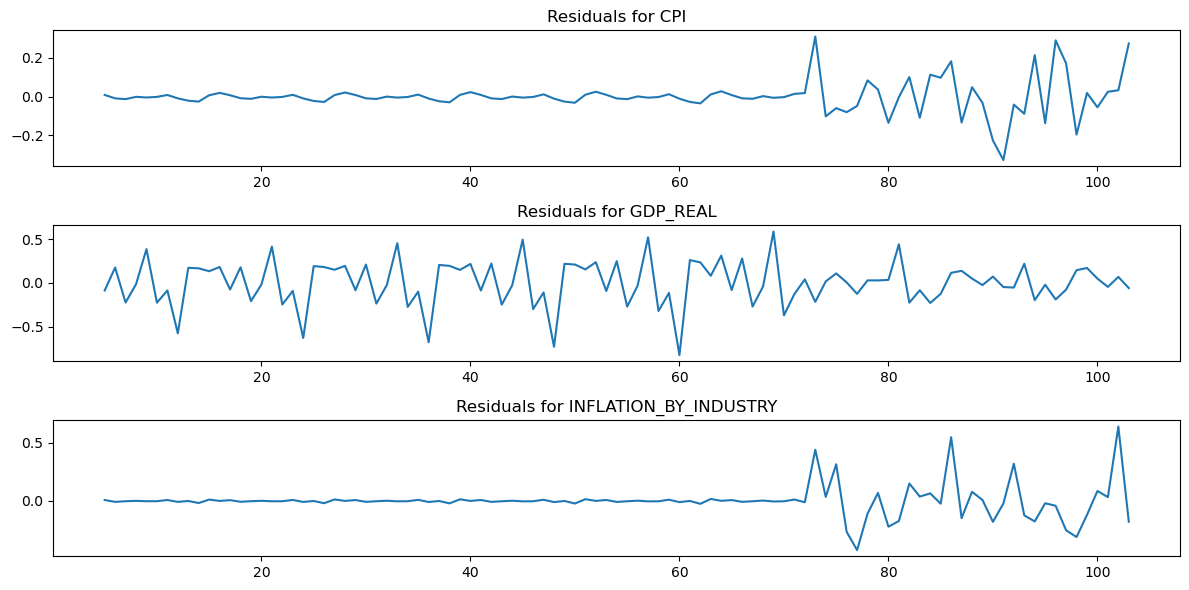

In [563]:
plt.figure(figsize=(12, len(fitted.resid.columns)*2))
for i, col in enumerate(fitted.resid.columns):
    plt.subplot(len(fitted.resid.columns), 1, i+1)
    plt.plot(fitted.resid[col])
    plt.title(f"Residuals for {col}")
plt.tight_layout()
plt.show()

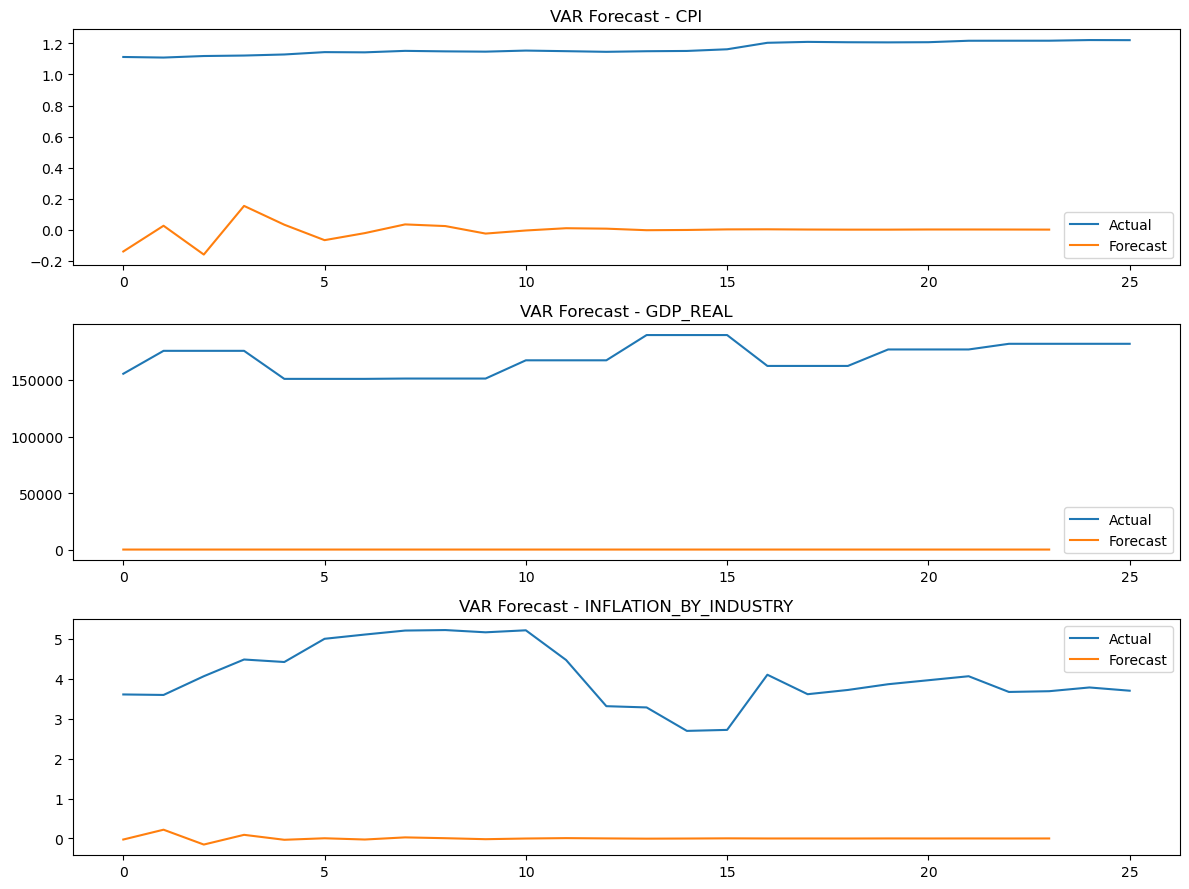

In [564]:
lag_order = fitted.k_ar   # số lag mô hình chọn
forecast_input = train_diff.values[-lag_order:]
forecast = fitted.forecast(y=forecast_input, steps=len(test_diff))

plt.figure(figsize=(12, len(train_diff.columns)*3))
for i, col in enumerate(train_diff.columns):
    plt.subplot(len(train_diff.columns), 1, i+1)
    plt.plot(test_data[col].values, label='Actual')
    plt.plot(forecast[:, i], label='Forecast')
    plt.title(f'VAR Forecast - {col}')
    plt.legend()

plt.tight_layout()
plt.show()


In [565]:
testY = test_diff.values
testY

array([[ 2.61918272e-01, -3.67759828e-01,  2.22543353e-01],
       [-1.30782625e-01,  0.00000000e+00, -2.31213873e-02],
       [ 7.28254160e-02, -4.49808393e-01, -2.22543353e-01],
       [ 1.58973282e-01,  4.49808393e-01,  2.97687861e-01],
       [-3.18161314e-01,  0.00000000e+00, -2.19653179e-01],
       [ 2.09522293e-01,  5.14982028e-03, -2.89017341e-03],
       [-2.45516792e-01, -5.14982028e-03, -4.04624277e-02],
       [ 2.78767743e-02,  0.00000000e+00, -3.17919075e-02],
       [ 1.67844506e-01,  2.92671379e-01,  4.91329480e-02],
       [-2.07481137e-01, -2.92671379e-01, -3.67052023e-01],
       [-5.89811543e-03,  0.00000000e+00, -1.90751445e-01],
       [ 1.53621949e-01,  4.05022485e-01,  5.20231214e-01],
       [-3.91116058e-02, -4.05022485e-01, -2.57225434e-01],
       [ 1.73275473e-01,  0.00000000e+00,  2.83236994e-01],
       [ 5.97986439e-01, -4.95286383e-01,  6.27167630e-01],
       [-6.91753992e-01,  4.95286383e-01, -8.64161850e-01],
       [-1.59173835e-01,  0.00000000e+00

In [566]:
def reverse_difference(last_observed, differenced):
    """
    last_observed: vector (no_columns,) - giá trị LEVEL cuối cùng trước đoạn diff
    differenced:   array (T, no_columns) - chuỗi sai phân cần khôi phục
    """
    restored = []
    prev = last_observed.astype(float).copy()
    for d in differenced:
        new = prev + d       # x_t = x_{t-1} + d_t
        restored.append(new)
        prev = new
    return np.array(restored)

In [567]:
lag_order = fitted.k_ar   # số lag mô hình chọn
testY = test_diff.values

In [568]:
pred_VAR = fitted.forecast(
    y=train_diff.values[-lag:],  # dùng các quan sát cuối của train_diff
    steps=len(testY)                   # số bước forecast = số mẫu test
)

In [569]:
pred_VAR = fitted.forecast(
    y=train_diff.values[-lag_order:],  # dùng các quan sát cuối của train_diff
    steps=len(testY)                   # số bước forecast = số mẫu test
)

In [570]:
def reverse_difference(original_data, differenced_data, order=1):
    reversed_data = []
    last_original_value = original_data.iloc[-len(differenced_data) - order:-order].values
    for i in range(len(differenced_data)):
        restored = differenced_data[i] + last_original_value[i]
        reversed_data.append(restored)
    return np.array(reversed_data)

In [571]:
last_test_values = scaled_test
testY_original = reverse_difference(last_test_values, testY, 2)
pred_VAR_original = reverse_difference(last_test_values, pred_VAR, 2)

In [572]:
def reverse_difference_cumulative(last_observed, differenced):
    # last_observed: vector (n_features,) là giá trị level ngay trước chuỗi cần khôi phục
    restored = []
    prev = last_observed.astype(float).copy()
    for d in differenced:
        prev = prev + d
        restored.append(prev.copy())
    return np.array(restored)

# Dùng giá trị cuối của TRAIN làm mốc
last_train_value = scaled_train.iloc[-1].values
testY_original = reverse_difference_cumulative(last_train_value, test_diff.values)
pred_VAR_original = reverse_difference_cumulative(last_train_value, pred_VAR)

# Unscale về gốc như hiện tại
unscaled_VARNN = unscale(pred_VAR_original)
originY        = unscale(testY_original)

In [573]:
last_test_values

,CPI,GDP_REAL,INFLATION_BY_INDUSTRY
104,1.171807,0.834884,0.543353
105,1.100512,1.202644,0.537572
106,1.291135,1.202644,0.754335
107,1.350976,1.202644,0.947977
108,1.483643,0.752836,0.919075
109,1.775282,0.752836,1.187861
110,1.748760,0.752836,1.236994
111,1.931761,0.757986,1.283237
112,1.869245,0.757986,1.289017
113,1.834605,0.757986,1.263006


In [574]:
testY_original

array([[ 1.26191827,  0.46712456,  0.39306358],
       [ 1.13113565,  0.46712456,  0.3699422 ],
       [ 1.20396106,  0.01731617,  0.14739884],
       [ 1.36293434,  0.46712456,  0.44508671],
       [ 1.04477303,  0.46712456,  0.22543353],
       [ 1.25429532,  0.47227438,  0.22254335],
       [ 1.00877853,  0.46712456,  0.18208092],
       [ 1.03665531,  0.46712456,  0.15028902],
       [ 1.20449981,  0.75979594,  0.19942197],
       [ 0.99701868,  0.46712456, -0.16763006],
       [ 0.99112056,  0.46712456, -0.3583815 ],
       [ 1.14474251,  0.87214705,  0.16184971],
       [ 1.1056309 ,  0.46712456, -0.09537572],
       [ 1.27890638,  0.46712456,  0.18786127],
       [ 1.87689282, -0.02816182,  0.8150289 ],
       [ 1.18513882,  0.46712456, -0.04913295],
       [ 1.02596499,  0.46712456,  0.22543353],
       [ 1.05514984,  0.73134097,  0.24277457],
       [ 1.09257117,  0.46712456,  0.22254335],
       [ 1.25182489,  0.46712456,  0.22254335],
       [ 1.07492928,  0.55793951, -0.005

In [575]:
pred_VAR_original

array([[0.86027176, 0.98251049, 0.14392436],
       [0.88621161, 0.67609924, 0.363279  ],
       [0.72671566, 0.88863082, 0.21080791],
       [0.8804229 , 0.802709  , 0.30166936],
       [0.9130457 , 0.97608012, 0.26865343],
       [0.84623239, 0.78167407, 0.27348955],
       [0.82481461, 0.84985165, 0.24725133],
       [0.85943428, 0.79536437, 0.27424706],
       [0.88332986, 0.90805419, 0.28082293],
       [0.85889733, 0.82855913, 0.26266934],
       [0.85437179, 0.85739431, 0.2613914 ],
       [0.86441266, 0.80730799, 0.26989398],
       [0.87162183, 0.86672465, 0.27118957],
       [0.86888822, 0.83346076, 0.26645112],
       [0.8676938 , 0.8574419 , 0.2646963 ],
       [0.87017741, 0.82221318, 0.26776183],
       [0.87322996, 0.8497589 , 0.26735992],
       [0.87483055, 0.83171501, 0.2669854 ],
       [0.87575698, 0.84983952, 0.26579914],
       [0.87663002, 0.82984761, 0.26642038],
       [0.87850385, 0.84287867, 0.26606999],
       [0.88037502, 0.83110103, 0.26629918],
       [0.

### Model Evaluation

In [576]:
def unscale(data):
    temp = data.copy()
    for index, i in enumerate(train_data.columns):
        scaler = scalers[i]
        temp[:, index] = scaler.inverse_transform(
            np.reshape(data[:, index], (-1, 1))
        ).flatten()
    return temp

In [577]:
pred_VAR_original

array([[0.86027176, 0.98251049, 0.14392436],
       [0.88621161, 0.67609924, 0.363279  ],
       [0.72671566, 0.88863082, 0.21080791],
       [0.8804229 , 0.802709  , 0.30166936],
       [0.9130457 , 0.97608012, 0.26865343],
       [0.84623239, 0.78167407, 0.27348955],
       [0.82481461, 0.84985165, 0.24725133],
       [0.85943428, 0.79536437, 0.27424706],
       [0.88332986, 0.90805419, 0.28082293],
       [0.85889733, 0.82855913, 0.26266934],
       [0.85437179, 0.85739431, 0.2613914 ],
       [0.86441266, 0.80730799, 0.26989398],
       [0.87162183, 0.86672465, 0.27118957],
       [0.86888822, 0.83346076, 0.26645112],
       [0.8676938 , 0.8574419 , 0.2646963 ],
       [0.87017741, 0.82221318, 0.26776183],
       [0.87322996, 0.8497589 , 0.26735992],
       [0.87483055, 0.83171501, 0.2669854 ],
       [0.87575698, 0.84983952, 0.26579914],
       [0.87663002, 0.82984761, 0.26642038],
       [0.87850385, 0.84287867, 0.26606999],
       [0.88037502, 0.83110103, 0.26629918],
       [0.

In [578]:
testY_original

array([[ 1.26191827,  0.46712456,  0.39306358],
       [ 1.13113565,  0.46712456,  0.3699422 ],
       [ 1.20396106,  0.01731617,  0.14739884],
       [ 1.36293434,  0.46712456,  0.44508671],
       [ 1.04477303,  0.46712456,  0.22543353],
       [ 1.25429532,  0.47227438,  0.22254335],
       [ 1.00877853,  0.46712456,  0.18208092],
       [ 1.03665531,  0.46712456,  0.15028902],
       [ 1.20449981,  0.75979594,  0.19942197],
       [ 0.99701868,  0.46712456, -0.16763006],
       [ 0.99112056,  0.46712456, -0.3583815 ],
       [ 1.14474251,  0.87214705,  0.16184971],
       [ 1.1056309 ,  0.46712456, -0.09537572],
       [ 1.27890638,  0.46712456,  0.18786127],
       [ 1.87689282, -0.02816182,  0.8150289 ],
       [ 1.18513882,  0.46712456, -0.04913295],
       [ 1.02596499,  0.46712456,  0.22543353],
       [ 1.05514984,  0.73134097,  0.24277457],
       [ 1.09257117,  0.46712456,  0.22254335],
       [ 1.25182489,  0.46712456,  0.22254335],
       [ 1.07492928,  0.55793951, -0.005

In [579]:
last_train_value = scaled_train.iloc[-1].values

In [580]:
testY_original    = reverse_difference(last_train_value, testY)
pred_VAR_original = reverse_difference(last_train_value, pred_VAR)

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [ ]:
unscaled_VARNN = unscale(pred_VAR_original)  # giữ nguyên tên biến
originY        = unscale(testY_original)

In [ ]:
unscaled_VARNN

array([[ 1.58221885e+00,  3.45190517e+05,  3.09643953e+01],
       [ 1.04685782e+00, -8.53329029e+04,  3.92370924e+00],
       [ 4.46028819e-01, -1.69707792e+06, -2.86837507e+00],
       [ 9.27181378e-01,  5.78750161e+05, -1.38260454e+01],
       [ 1.23076634e+00,  2.53790923e+06, -4.31567602e+01],
       [ 1.05003907e+00, -5.64333701e+06, -9.35352747e+00],
       [-6.17245686e-01,  1.96605241e+06, -5.99234332e+01],
       [ 1.38696266e+00,  6.88211234e+06,  1.76590885e+01],
       [ 3.02814904e+00,  5.81413799e+06, -7.32339622e-01],
       [ 3.21996048e+00, -4.23375049e+06,  1.85991327e+02],
       [-1.13397346e-01, -2.62747507e+06,  1.29043495e+02],
       [-1.08109534e-01,  2.90250110e+06,  3.77973027e+01],
       [ 3.69780034e+00, -3.91440064e+06, -2.71690410e+01],
       [ 1.61536337e+00, -8.75118500e+06, -4.94982509e+01],
       [-2.53950672e+00, -3.33824177e+05, -7.15460088e+01],
       [-7.34010848e-02,  7.57975801e+06, -1.51264555e+02],
       [ 3.22535242e+00, -1.27528194e+06

In [ ]:
originY

array([[1.11721679e+00, 1.35235389e+05, 3.28125000e+00],
       [1.11043939e+00, 1.35235389e+05, 3.23125000e+00],
       [1.11421334e+00, 1.10429556e+05, 2.75000000e+00],
       [1.12245163e+00, 1.35235389e+05, 3.39375000e+00],
       [1.10596392e+00, 1.35235389e+05, 2.91875000e+00],
       [1.11682175e+00, 1.35519389e+05, 2.91250000e+00],
       [1.10409862e+00, 1.35235389e+05, 2.82500000e+00],
       [1.10554324e+00, 1.35235389e+05, 2.75625000e+00],
       [1.11424126e+00, 1.51375500e+05, 2.86250000e+00],
       [1.10348920e+00, 1.35235389e+05, 2.06875000e+00],
       [1.10318355e+00, 1.35235389e+05, 1.65625000e+00],
       [1.11114452e+00, 1.57571389e+05, 2.78125000e+00],
       [1.10911769e+00, 1.35235389e+05, 2.22500000e+00],
       [1.11809714e+00, 1.35235389e+05, 2.83750000e+00],
       [1.14908591e+00, 1.07921556e+05, 4.19375000e+00],
       [1.11323794e+00, 1.35235389e+05, 2.32500000e+00],
       [1.10498925e+00, 1.35235389e+05, 2.91875000e+00],
       [1.10650167e+00, 1.49806

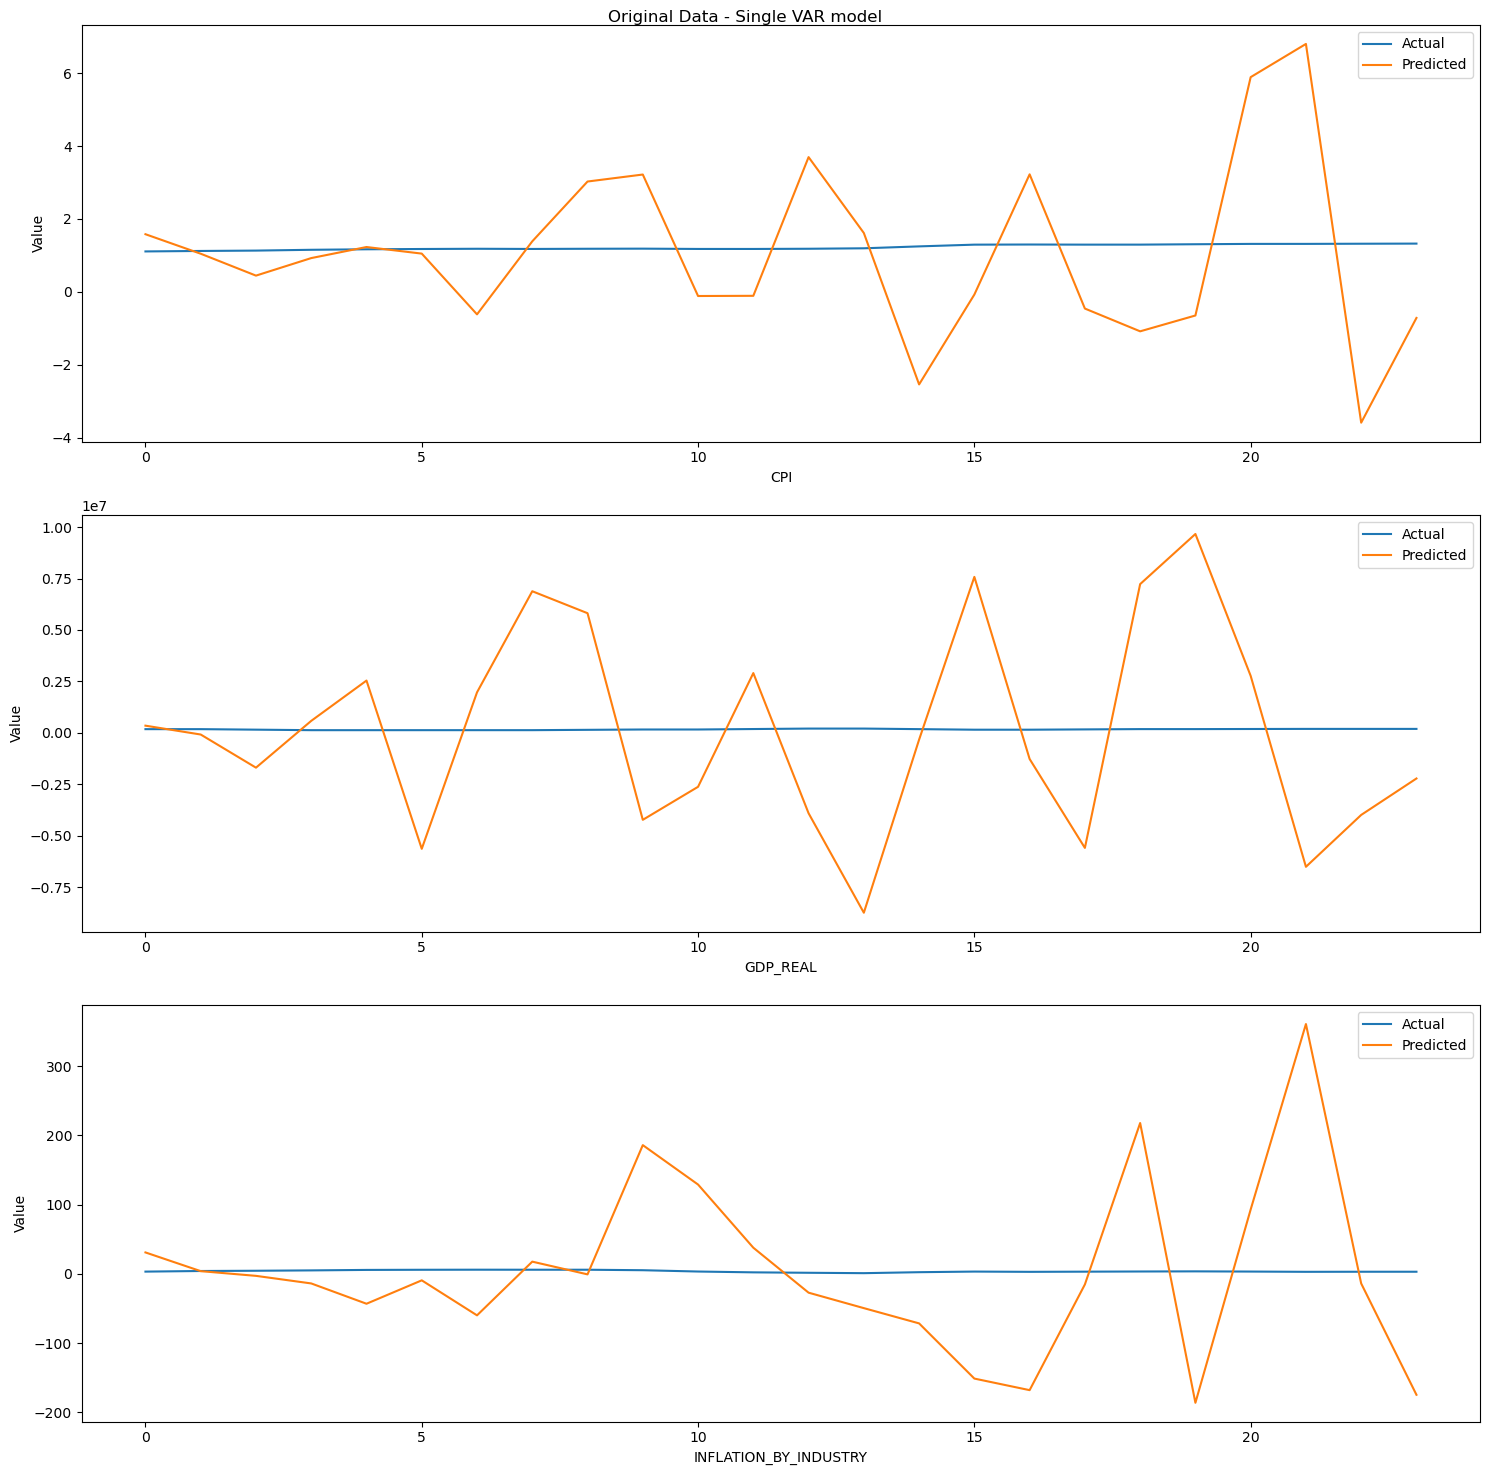

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(no_columns):
    plt.subplot(no_columns, 1, i+1)
    plt.plot(originY[:, i], label='Actual')
    plt.plot(unscaled_VARNN[:, i], label='Predicted')
    plt.title('')
    plt.xlabel(f'{scaled_test.columns[i]}')
    plt.ylabel('Value')
    plt.legend()

plt.suptitle('Original Data - Single VAR model')
plt.tight_layout()
plt.show()

#### MSE

In [ ]:
for i in range(no_columns):
    print(f'MSE for {scaled_test.columns[i]}: {mean_squared_error(originY[:, i], unscaled_VARNN[:, i])}')
    
print(f'MSE total: {mean_squared_error(originY, unscaled_VARNN)}')

#### RMSE

In [ ]:
for i in range(no_columns):
    rmse = np.sqrt(mean_squared_error(originY[:, i], unscaled_VARNN[:, i]))
    print(f'RMSE for {scaled_test.columns[i]}: {rmse}')

total_rmse = np.sqrt(mean_squared_error(originY, unscaled_VARNN))
print(f'RMSE total: {total_rmse}')

#### MAE

In [ ]:
for i in range(no_columns):
    print(f'MAE for {scaled_test.columns[i]}: {mean_absolute_error(originY[:, i], unscaled_VARNN[:, i])}')
    
print(f'MAE total: {mean_absolute_error(originY, unscaled_VARNN)}')

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(no_columns):
    plt.subplot(no_columns, 1, i+1)
    plt.plot(originY[:, i], label='Actual')
    plt.plot(unscaled_VARNN[:, i], label='Predicted')
    plt.title('')
    plt.xlabel(f'{scaled_test.columns[i]}')
    plt.ylabel('Value')
    plt.legend()

plt.suptitle('Original Data')
plt.tight_layout()
plt.show()

In [ ]:
evaluation_results = []

for lag in range(1, 21):
    try:
        print(f"\n================== TESTING LAG = {lag} ==================")

        # Train VAR
        model = VAR(train_diff)
        fitted = model.fit(maxlags=lag)

        # Lấy số lag thực tế mà VAR chọn (<= lag)
        lag_order = fitted.k_ar   

        print(f"VAR selected effective lag = {lag_order}")
        print("AIC:", fitted.aic, "  BIC:", fitted.bic)

        # Dự báo differenced output
        pred_VAR = fitted.forecast(
            train_diff.values[-lag_order:], 
            steps=len(test_diff)
        )

        # Khôi phục thực & dự báo ngược về level
        last_train_value = scaled_train.iloc[-1].values    

        testY_original    = reverse_difference(last_train_value, test_diff.values)
        pred_VAR_original = reverse_difference(last_train_value, pred_VAR)

        # Unscale về giá trị thực
        unscaled_VAR = unscale(pred_VAR_original)
        originY      = unscale(testY_original)

        # Tính chỉ số đánh giá
        mse_lst, rmse_lst, mae_lst = [], [], []
        for i in range(no_columns):
            mse  = mean_squared_error(originY[:, i], unscaled_VAR[:, i])
            rmse = np.sqrt(mse)
            mae  = mean_absolute_error(originY[:, i], unscaled_VAR[:, i])
            mse_lst.append(mse); rmse_lst.append(rmse); mae_lst.append(mae)

        total_mse  = mean_squared_error(originY, unscaled_VAR)
        total_rmse = np.sqrt(total_mse)
        total_mae  = mean_absolute_error(originY, unscaled_VAR)

        evaluation_results.append({
            'lag': lag,
            'MSE_CPI': mse_lst[0],
            'MSE_GDP_REAL': mse_lst[1],
            'MSE_INFLATION_BY_INDUSTRY': mse_lst[2],
            'RMSE_CPI': rmse_lst[0],
            'RMSE_GDP_REAL': rmse_lst[1],
            'RMSE_INFLATION_BY_INDUSTRY': rmse_lst[2],
            'MAE_CPI': mae_lst[0],
            'MAE_GDP_REAL': mae_lst[1],
            'MAE_INFLATION_BY_INDUSTRY': mae_lst[2],
            'Total_MSE': total_mse,
            'Total_RMSE': total_rmse,
            'Total_MAE': total_mae
        })

        # Vẽ plot so sánh Actual vs Forecast
        plt.figure(figsize=(15, 15))
        for i in range(no_columns):
            plt.subplot(no_columns, 1, i+1)
            plt.plot(originY[:, i], label='Actual (True)')
            plt.plot(unscaled_VAR[:, i], label='Forecast (VAR)')
            plt.xlabel(f'{scaled_test.columns[i]}')
            plt.ylabel('Value'); plt.legend()

        plt.suptitle(f'Actual vs Forecast - VAR (lag={lag})')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f'Lag {lag} caused an error -> {e}')

In [ ]:
evaluation_results

In [ ]:
evaluation_df = pd.DataFrame(evaluation_results)
evaluation_df

## GEEKSFORGEEKS

In [ ]:
def plot_series(data):
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 8))
    for i, col in enumerate(data.columns):
        data[col].plot(ax=axes[i], title=col)
        axes[i].set_ylabel('Values')
        axes[i].set_xlabel('Date')
    plt.tight_layout()
    plt.show()
    
plot_series(macro_pd)

In [ ]:
# Check stationarity of time series using ADF test
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [ ]:
# Section for VAR analysis
def var_analysis(data):
    # Step 1: Check stationarity and visualize the original data
    print("Step 1: Checking stationarity")
    for col in data.columns:
        print('Stationarity test for', col)
        check_stationarity(data[col])

    # Step 2: Applying VAR model
    print("\nStep 2: Applying VAR model")
    model = VAR(data)
    results = model.fit()

    # Step 3: Forecasting
    print("\nStep 3: Forecasting")
    lag_order = results.k_ar
    forecast = results.forecast(data.values[-lag_order:], steps=10)

    # Step 4: Visualizing forecast
    print("\nStep 4: Visualizing forecast")
    forecast_index = pd.date_range(start='2024-04-11', periods=10)
    forecast_data = pd.DataFrame(forecast, index=forecast_index, columns=data.columns)
    plot_series(pd.concat([data, forecast_data]))

# Perform VAR analysis
var_analysis(macro_pd)

In [ ]:
# Section for VAR analysis
def var_analysis(data):
    # Step 0: Train/Test split 80/20
    print("Step 0: Train/Test split 80/20")
    n = len(data)
    train_size = int(n * 0.8)
    train = data.iloc[:train_size].copy()
    test  = data.iloc[train_size:].copy()
    print(f"Train shape: {train.shape}, Test shape: {test.shape}")
    
    # Step 1: Check stationarity (trên train)
    print("\nStep 1: Checking stationarity on TRAIN")
    for col in train.columns:
        print('Stationarity test for', col)
        check_stationarity(train[col])

    # Step 2: Fit VAR model trên train
    print("\nStep 2: Fitting VAR model on TRAIN")
    model = VAR(train)
    results = model.fit()   # có thể thêm maxlags / ic nếu bạn muốn

    print(results.summary())

    # Step 3: Forecast cho phần TEST
    print("\nStep 3: Forecasting TEST period")
    lag_order = results.k_ar
    print("Selected lag order (k_ar):", lag_order)

    # dùng các quan sát cuối của train để khởi tạo
    forecast_values = results.forecast(train.values[-lag_order:], steps=len(test))

    forecast_df = pd.DataFrame(
        forecast_values,
        index=test.index,           # align theo index của test
        columns=data.columns
    )

    # Step 4: Visualizing forecast vs actual trên TEST
    print("\nStep 4: Visualizing forecast vs actual on TEST set")

    fig, axes = plt.subplots(nrows=len(data.columns), ncols=1, figsize=(12, 8))
    if len(data.columns) == 1:
        axes = [axes]  # đảm bảo iterable

    for i, col in enumerate(data.columns):
        # Train actual
        axes[i].plot(train.index, train[col], label='Train Actual', color='blue')
        # Test actual
        axes[i].plot(test.index, test[col], label='Test Actual', color='black')
        # Forecast
        axes[i].plot(forecast_df.index, forecast_df[col],
                     label='Forecast', color='red', linestyle='--')
        axes[i].set_title(col)
        axes[i].set_ylabel('Values')
        axes[i].legend()

    axes[-1].set_xlabel('Index')
    plt.tight_layout()
    plt.show()

    # Optional: trả về để bạn dùng tiếp nếu cần
    return train, test, forecast_df, results

In [ ]:
# Perform VAR analysis
train_var, test_var, forecast_var, results_var = var_analysis(macro_pd)